<a href="https://colab.research.google.com/github/iliaxant/HR_Extraction_from_Video/blob/main/HR_Extraction_from_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Εκτίμηση καρδιακής συχνότητας από βίντεο (πρόσωπο ή δάχτυλο) - Ψηφιακή Επεξεργασία Εικόνας**

## Εξαμηνιαία Εργασία - Ακαδημαικό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/HR_Extraction_from_Video

## **Part 0**: Set-Up

1) Mount Google drive and load subject of dataset. (Change zip_path to match your zip file directory).

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Subject 2, 6, 7, 19, 21, 28 and 29 data not available either due to data share
# disagreement or due to technical issues
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/subject45.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


2) Install and import libraries.

In [3]:
from google.colab import drive
import zipfile
import os

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

## **Part 1**: Data Preparation

============ Video Info ============

Resolution:       640 x 480
Frame Rate (FPS): 29.951
Frame Count:      2032
Duration:         1:07.845 (67.845s)




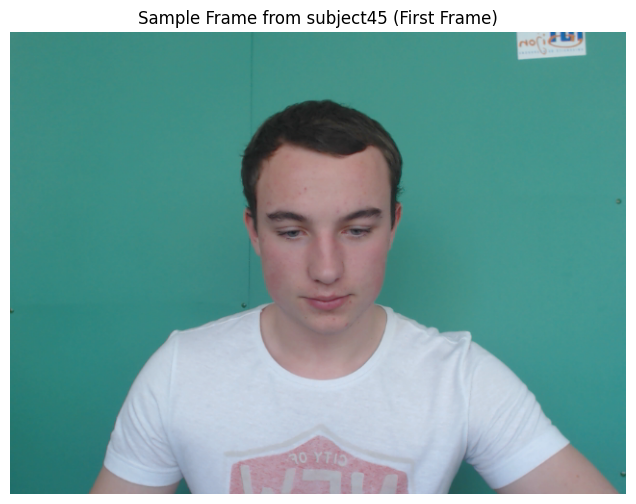

In [24]:
# Input subject num
# ----------------------
num = '45'
# ----------------------

subject_path = f'/content/subject{num}'
video_path = os.path.join(subject_path, 'vid.avi')
gt_path = os.path.join(subject_path, 'ground_truth.txt')


cap = cv2.VideoCapture(video_path)

ret, frame_bgr = cap.read()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_duration_secs = frame_count / fps

cap.release()

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

minutes = int(video_duration_secs // 60)
seconds = int(video_duration_secs % 60)
milliseconds = round((video_duration_secs - int(video_duration_secs)) * 1000)

video_duration_full_time = f"{minutes}:{seconds:02d}.{milliseconds:03d}"

print("============ Video Info ============\n")

print(f"Resolution:       {width} x {height}")
print(f"Frame Rate (FPS): {fps:.3f}")
print(f"Frame Count:      {frame_count}")
print(f"Duration:         {video_duration_full_time} ({video_duration_secs:.3f}s)\n")

print("====================================\n")

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title(f"Sample Frame from subject{num} (First Frame)")
plt.axis('off')
plt.show()


========= Ground Truth Info =========

PPG signal/Time/HR samples: 2032
Time range: 0.000s to 67.828s
Sampling rate (estimated): 29.943 Hz

PPG signal (first 10 samples): [-0.804 -0.898 -0.851 -0.772 -0.873 -1.036 -1.276 -1.452 -1.496 -1.464]
PPG signal mean: -0.000
PPG signal Standard Deviation: 0.985

Time in seconds (first 10 samples): [0.    0.033 0.066 0.099 0.132 0.165 0.202 0.233 0.275 0.297]
Difference of sampling times (first 10 values): [0.033 0.033 0.033 0.033 0.033 0.037 0.031 0.042 0.022 0.035]
Difference of sampling times mean: 0.033
Difference of sampling times Standard Deviation: 0.008

HR in bpm (first 10 samples): [96 96 96 96 96 96 96 96 96 96]
HR mean: 110.820
HR Standard Deviation: 5.009




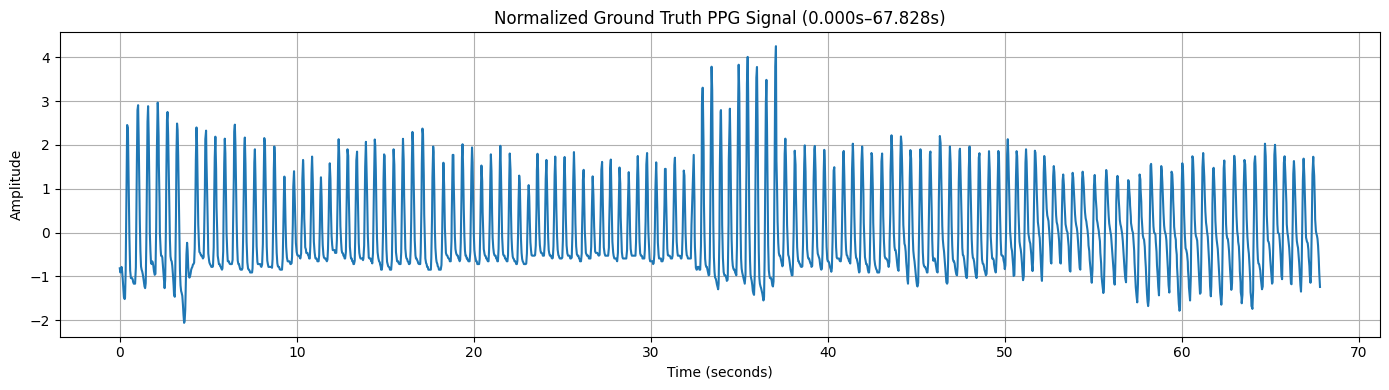

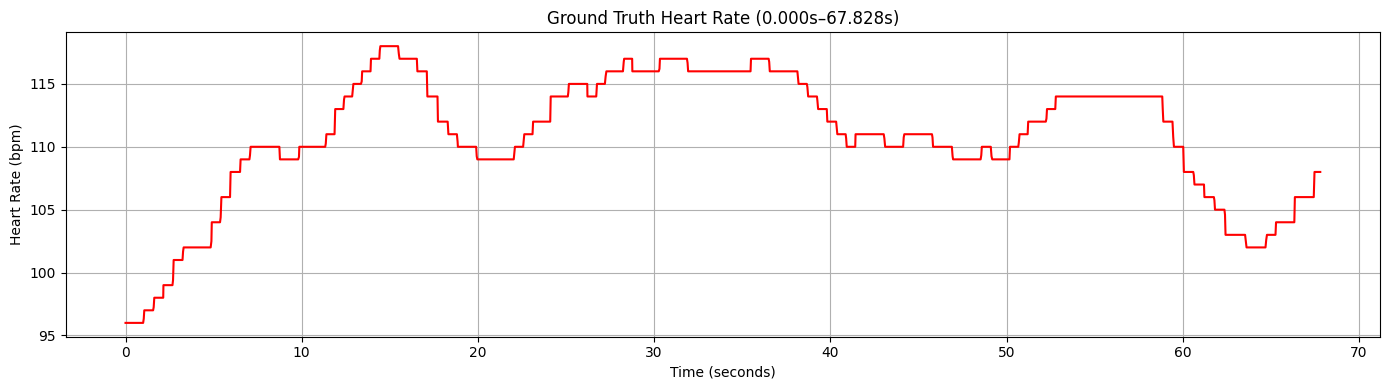

In [38]:
gt_data = np.loadtxt(gt_path)

gt_ppg = gt_data[0, :]
gt_hr = gt_data[1, :]
gt_time = gt_data[2, :]


# Input start time and duration (in seconds) for PPG signal plot.
# ----------------------
start_time = 0
segment_duration = gt_time[-1]    # Signal lasts gt_time[-1] seconds.
# ----------------------


gt_ppg_norm= (gt_ppg - np.mean(gt_ppg)) / np.std(gt_ppg)

samp_time_diff = np.diff(gt_time)

end_time = start_time + segment_duration
start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)


print("========= Ground Truth Info =========\n")

print(f"PPG signal/Time/HR samples: {len(gt_ppg)}")
print(f"Time range: {gt_time[0]:.3f}s to {gt_time[-1]:.3f}s")
print(f"Sampling rate (estimated): {1/np.mean(np.diff(gt_time)):.3f} Hz\n")

print(f"PPG signal (first 10 samples): {np.round(gt_ppg[:10], 3)}")
print(f"PPG signal mean: {np.mean(gt_ppg):.3f}")
print(f"PPG signal Standard Deviation: {np.std(gt_ppg):.3f}\n")

print(f"Time in seconds (first 10 samples): {gt_time[:10]}")
print(f"Difference of sampling times (first 10 values): {samp_time_diff[:10]}")
print(f"Difference of sampling times mean: {np.mean(samp_time_diff):.3f}")
print(f"Difference of sampling times Standard Deviation: {np.std(samp_time_diff):.3f}\n")

print(f"HR in bpm (first 10 samples): {gt_hr[:10].astype(int)}")
print(f"HR mean: {np.mean(gt_hr):.3f}")
print(f"HR Standard Deviation: {np.std(gt_hr):.3f}\n")

print("=====================================\n")

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_ppg_norm[start_samp:end_samp])
plt.title(f"Normalized Ground Truth PPG Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r')
plt.title(f"Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()